In [1]:
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel
from diffusers.utils import load_image
import numpy as np
import torch


: 

In [1]:

init_image = load_image(
    "https://huggingface.co/datasets/diffusers/test-arrays/resolve/main/stable_diffusion_inpaint/boy.png"
)
init_image = init_image.resize((512, 512))

generator = torch.Generator(device="cpu").manual_seed(1)

mask_image = load_image(
    "https://huggingface.co/datasets/diffusers/test-arrays/resolve/main/stable_diffusion_inpaint/boy_mask.png"
)
mask_image = mask_image.resize((512, 512))


def make_inpaint_condition(image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
    image[image_mask > 0.5] = -1.0  # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image


control_image = make_inpaint_condition(init_image, mask_image)

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# generate image
image = pipe(
    "a handsome man with ray-ban sunglasses",
    num_inference_steps=20,
    generator=generator,
    eta=1.0,
    image=init_image,
    mask_image=mask_image,
    control_image=control_image,
).images[0]

/Users/elray/miniconda3/envs/outpaint/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

In [1]:
from data_pipeline.loader import FluDataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fdl = FluDataLoader('../flusion/data-raw')

ilinet_adj = fdl.load_ilinet(scale_to_positive=True, drop_pandemic_seasons=False)


In [4]:
flu_data = fdl.load_data()

In [51]:
train_df = flu_data.query(
  'agg_level == "state" and wk_end_date <= "2017-12-01" and source == "ilinet" and location < "72"')
train_df

,agg_level,location,season,season_week,wk_end_date,inc,source,pop,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
9252,state,01,2010/11,10.0,2010-10-09,0.003648,ilinet,4785437.0,15.381088,0.341793,1.875259,-0.332875,0.514173
9253,state,01,2010/11,11.0,2010-10-16,0.003648,ilinet,4785437.0,15.381088,0.341793,1.875259,-0.332875,0.514173
9254,state,01,2010/11,12.0,2010-10-23,0.145043,ilinet,4785437.0,15.381088,0.627499,1.875259,-0.181328,0.514173
9255,state,01,2010/11,13.0,2010-10-30,0.714826,ilinet,4785437.0,15.381088,0.922696,1.875259,-0.024747,0.514173
9256,state,01,2010/11,14.0,2010-11-06,1.810421,ilinet,4785437.0,15.381088,1.161564,1.875259,0.101956,0.514173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43470,state,56,2017/18,13.0,2017-10-28,NaN,ilinet,578931.0,13.268939,NaN,1.704083,NaN,0.555038
43471,state,56,2017/18,14.0,2017-11-04,NaN,ilinet,578931.0,13.268939,NaN,1.704083,NaN,0.555038
43472,state,56,2017/18,15.0,2017-11-11,NaN,ilinet,578931.0,13.268939,NaN,1.704083,NaN,0.555038
43473,state,56,2017/18,16.0,2017-11-18,NaN,ilinet,578931.0,13.268939,NaN,1.704083,NaN,0.555038


In [52]:
train_img = train_df[['location', 'wk_end_date', 'inc_4rt']] \
  .set_index(['wk_end_date', 'location']) \
  .unstack('location') \
  .values

keep_locs = ~np.all(np.isnan(train_img), axis = 0)
train_img = np.transpose(train_img[:, keep_locs])

a = np.nanmin(train_img)
b = np.nanmax(train_img)

train_img = (train_img - a) / (b - a) * 0.8

In [53]:
train_img.shape

(48, 373)

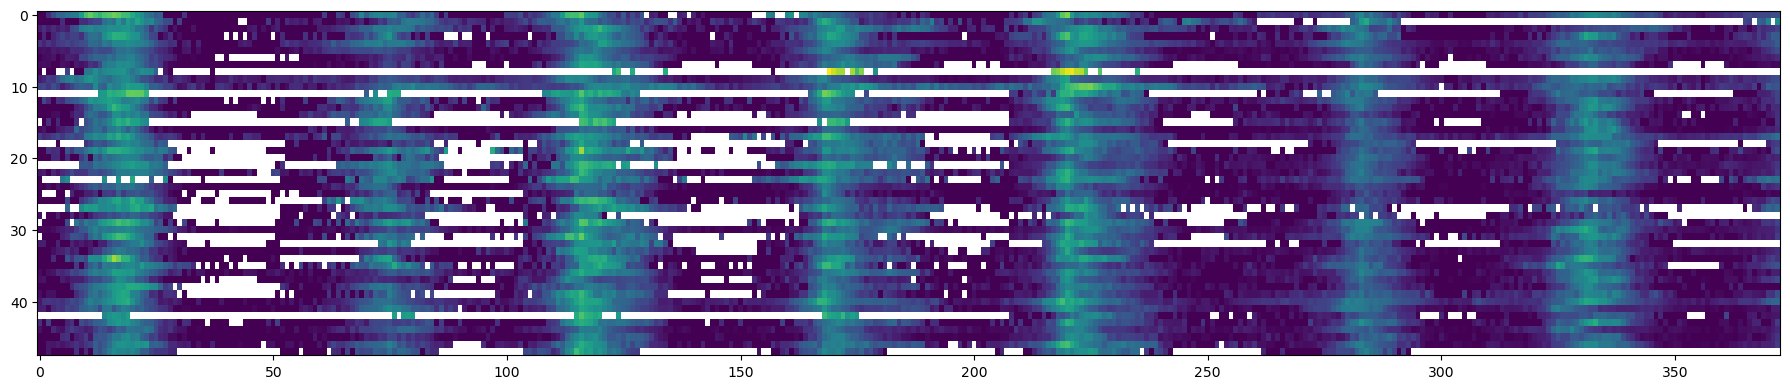

In [61]:
fig, ax = plt.subplots(figsize=(18, 4))
ax.imshow(train_img, interpolation='nearest', aspect = 'auto')
plt.tight_layout()


In [62]:
train_img_aug = np.concatenate(
  [train_img, np.full((train_img.shape[0], 12), np.nan)],
   axis = 1)
mask = np.isnan(train_img_aug)
mask

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])